# Introduction

Notebook de avaliação de serviço BiopassID ICAO Check em comparação com ground truth FVC-ICAO.

# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import numpy as np
import pandas as pd

if '../../../../notebooks/' not in sys.path:
    sys.path.insert(0, '../../../../notebooks/')

from net_data_loaders.net_gt_loader import NetGTLoader
from gt_loaders.gt_names import GTName
from utils.constants import ICAO_REQ
from vsoft_evaluator import VsoftEvaluator, DataSource

# Load Ground Truth

In [3]:
net_gt_loader = NetGTLoader(aligned=False, gt_names=[GTName.FVC], requisites=list(ICAO_REQ), is_mtl_model=False)
train_data = net_gt_loader.load_gt_data(split='train')
valid_data = net_gt_loader.load_gt_data(split='validation')
test_data = net_gt_loader.load_gt_data(split='test')

Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4928, 26)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 26)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 26)


# Load Vsoft Data

In [4]:
data_df = pd.read_csv('vsoft_data/compliance_check_vsoft.csv')
print(data_df.shape)

ignore_imgs = data_df[data_df.mouth != -99].img_name
print(len(ignore_imgs))

data_df = data_df[~data_df.img_name.isin(ignore_imgs)]
print(data_df.shape)

(5763, 25)
830
(4933, 25)


In [22]:
data_df.head()

,origin,img_name,mouth,rotation,l_away,eyes_closed,close,hat,dark_glasses,frames_heavy,...,sh_face,sh_head,blurred,ink_mark,skin_tone,washed_out,pixelation,hair_eyes,background,red_eyes
8,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
24,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
39,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
51,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
52,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99


# Calculate Metrics

In [6]:
def select_vsoft_data(vsoft_data_df, data_src):
    if data_src == DataSource.TEST:
        return vsoft_data_df[vsoft_data_df.img_name.isin(test_data.img_name)]
    elif data_src == DataSource.VALIDATION:
        return vsoft_data_df[vsoft_data_df.img_name.isin(valid_data.img_name)]

## Test Split

Testing VSOFT BiopassID ICAO CHECK
Requisite: MOUTH
[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.]
float64
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99.]
float64


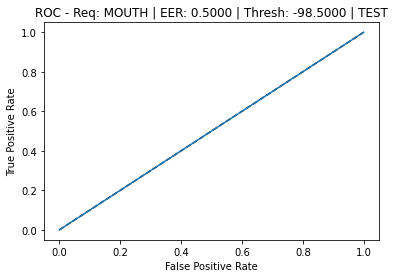

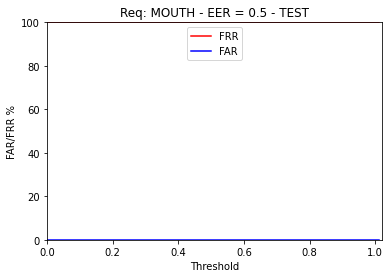

Requisite: MOUTH - EER_interp: 50.0% - Best Threshold: -98.5
Classification report -----------------------------------
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40        73
         1.0       0.00      0.00      0.00       215

    accuracy                           0.25       288
   macro avg       0.13      0.50      0.20       288
weighted avg       0.06      0.25      0.10       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 100.0% | EER_mean: 50.0% | TP: 0 | TN: 73 | FP: 0 | FN: 215
Accuracy ------------------------------------------------
Model Accuracy: 25.35%
---------------------------------------------------------


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
data_src = DataSource.TEST

vsoft_ev = VsoftEvaluator(data_src=data_src)
tmp_df = select_vsoft_data(data_df, data_src)

for req in list(ICAO_REQ)[:1]:
    if req != ICAO_REQ.INK_MARK:
        y_true = np.array([float(x) for x in test_data[req.value].values])
        y_hat = np.array([float(x) for x in tmp_df[req.value].values])
        vsoft_ev.calculate_metrics(y_true=y_true, y_hat=y_hat, requisite=req)